In [4]:
# Cell: Imports and constants
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import folium
from folium.plugins import HeatMap
import joblib

DATA_PATH = '/mnt/data/india_crime_dataset_1200.csv'
OUTPUT_DIR = '/mnt/data/crime_hotspot_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

sns.set(style='whitegrid')


In [7]:
df = pd.read_csv("india_crime_dataset_1200.csv")
print('Rows, Cols:', df.shape)
df.head()


Rows, Cols: (1200, 8)


,crime_id,city,crime_type,date_time,latitude,longitude,location_desc,police_zone
0,1,Chennai,Fraud,2023-04-23 23:00:00,13.064001,80.252974,Mall,Zone 1
1,2,Mumbai,Fraud,2023-09-01 04:00:00,19.075998,72.894904,Highway,Zone 1
2,3,Jaipur,Robbery,2023-11-22 11:00:00,26.918525,75.789806,Home,Zone 1
3,4,Lucknow,Vandalism,2023-05-11 20:00:00,26.859179,80.932848,Highway,Zone 4
4,5,Pune,Cyber Crime,2023-09-10 09:00:00,18.518840,73.849131,Highway,Zone 2


In [8]:
df.info()
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   crime_id       1200 non-null   int64  
 1   city           1200 non-null   object 
 2   crime_type     1200 non-null   object 
 3   date_time      1200 non-null   object 
 4   latitude       1200 non-null   float64
 5   longitude      1200 non-null   float64
 6   location_desc  1200 non-null   object 
 7   police_zone    1200 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 75.1+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
crime_id,1200.0,NaN,NaN,NaN,600.5,346.554469,1.0,300.75,600.5,900.25,1200.0
city,1200,10,Kolkata,130,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crime_type,1200,8,Robbery,173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_time,1200,1119,2023-10-04 06:00:00,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,1200.0,NaN,NaN,NaN,20.986446,5.344368,12.951947,17.386418,22.55386,26.848525,28.723876
longitude,1200.0,NaN,NaN,NaN,77.948131,4.549041,72.551692,73.86198,77.580212,80.276236,88.383754
location_desc,1200,8,Market,166,NaN,NaN,NaN,NaN,NaN,NaN,NaN
police_zone,1200,4,Zone 4,315,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# normalize column names
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

# heuristics to find date/lat/lon columns
date_col = next((c for c in df.columns if 'date' in c.lower()), None)
lat_col  = next((c for c in df.columns if 'lat' in c.lower()), None)
lon_col  = next((c for c in df.columns if 'lon' in c.lower() or 'lng' in c.lower()), None)

print('Detected columns -> date:', date_col, 'lat:', lat_col, 'lon:', lon_col)


Detected columns -> date: date_time lat: latitude lon: longitude


In [10]:
if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df['Date'] = df[date_col]
else:
    df['Date'] = pd.NaT

# Extract time features when present
df['Month'] = df['Date'].dt.month
df['Hour'] = df['Date'].dt.hour
df['DayOfWeek'] = df['Date'].dt.day_name()


In [11]:
# cast lat/lon to numeric
df['Latitude'] = pd.to_numeric(df[lat_col], errors='coerce') if lat_col else np.nan
df['Longitude'] = pd.to_numeric(df[lon_col], errors='coerce') if lon_col else np.nan

before = len(df)
df = df.dropna(subset=['Latitude','Longitude']).reset_index(drop=True)
print(f'Dropped {before - len(df)} rows without coordinates; remaining {len(df)}')


Dropped 0 rows without coordinates; remaining 1200


In [15]:
# normalize city and crime type columns
city_col = next((c for c in df.columns if 'city' in c.lower()), None)
crime_col = next((c for c in df.columns if 'crime' in c.lower()), None)

df['City'] = df[city_col].astype(str).str.title().str.strip() if city_col else 'Unknown'
df['CrimeType'] = df[crime_col].astype(str).str.title().str.strip() if crime_col else 'Other'


In [14]:
df.columns
df['city'].value_counts().head(15)
df['crime_type'].value_counts().head(15)


crime_type
Robbery        173
Assault        159
Cyber Crime    152
Vandalism      148
Fraud          145
Kidnapping     143
Burglary       143
Theft          137
Name: count, dtype: int64

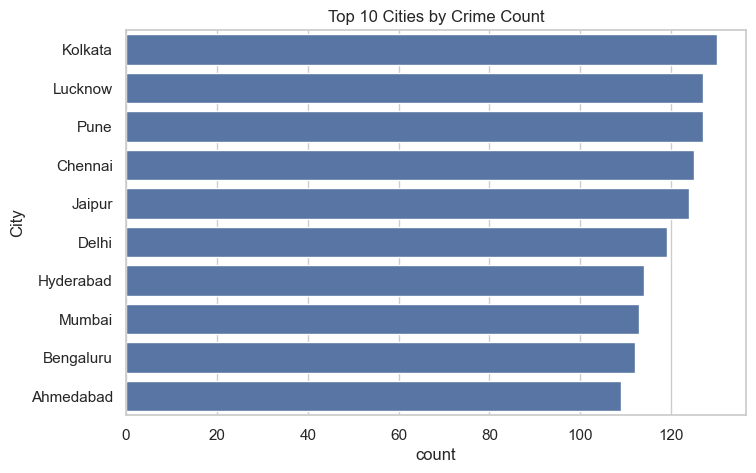

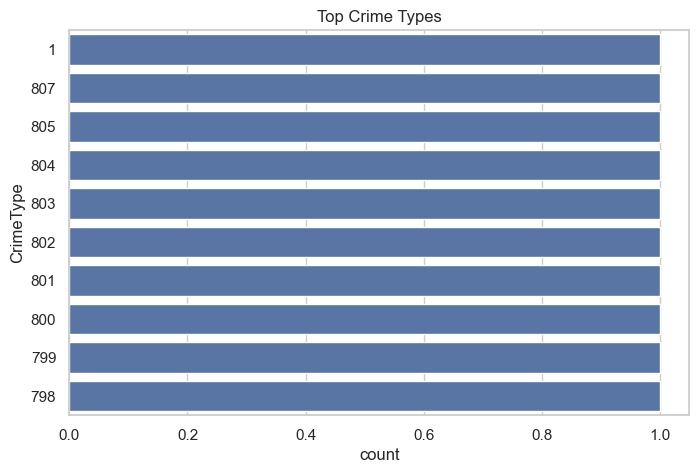

In [16]:
plt.figure(figsize=(8,5))
sns.countplot(y='City', data=df, order=df['City'].value_counts().index[:10])
plt.title('Top 10 Cities by Crime Count')
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(y='CrimeType', data=df, order=df['CrimeType'].value_counts().index[:10])
plt.title('Top Crime Types')
plt.show()


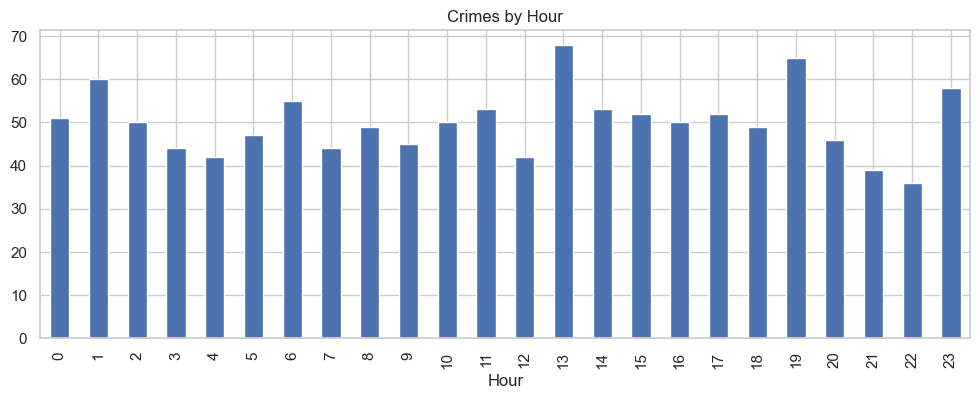

In [17]:
if df['Hour'].notna().any():
    df['Hour'].dropna().astype(int).value_counts().sort_index().plot(kind='bar', figsize=(12,4))
    plt.title('Crimes by Hour')
    plt.show()


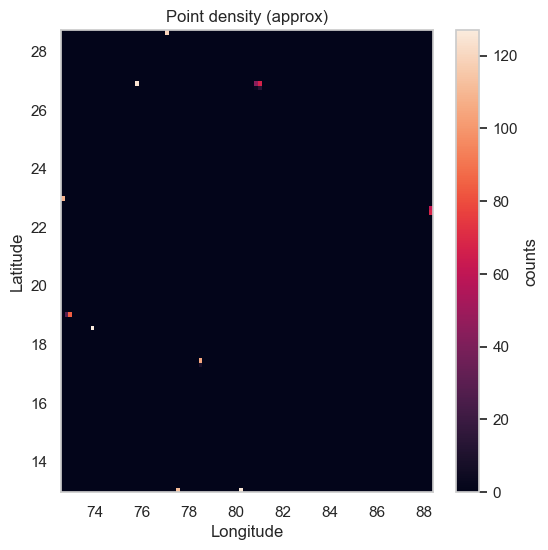

In [18]:
plt.figure(figsize=(6,6))
plt.hist2d(df['Longitude'], df['Latitude'], bins=100)
plt.xlabel('Longitude'); plt.ylabel('Latitude'); plt.title('Point density (approx)')
plt.colorbar(label='counts')
plt.show()


In [19]:
coords = df[['Latitude','Longitude']].to_numpy()
# starting eps (deg). Rough rule: 0.01 ~ ~1km (varies with latitude)
eps = 0.01
min_samples = max(5, int(0.01 * len(df)))  # e.g., at least 1% of data or 5

db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
labels = db.fit_predict(coords)
df['Cluster'] = labels
print('Unique clusters:', np.unique(labels))
df['Cluster'].value_counts().head(10)


Unique clusters: [0 1 2 3 4 5 6 7 8 9]


Cluster
4    130
2    127
3    127
6    125
1    124
5    119
8    114
0    113
9    112
7    109
Name: count, dtype: int64

In [20]:
# label hotspot = belongs to cluster (cluster != -1)
df['is_hotspot'] = (df['Cluster'] != -1).astype(int)
df['is_hotspot'].value_counts()


is_hotspot
1    1200
Name: count, dtype: int64

In [21]:
cluster_summary = df[df['Cluster'] != -1].groupby('Cluster').agg(
    Count=('Cluster', 'size'),
    Lat=('Latitude', 'mean'),
    Lon=('Longitude', 'mean')
).reset_index().sort_values('Count', ascending=False)
cluster_summary.head(10)


,Cluster,Count,Lat,Lon
4,4,130,22.572381,88.364288
2,2,127,26.845582,80.947083
3,3,127,18.519689,73.857354
6,6,125,13.083993,80.269199
1,1,124,26.912366,75.788637
5,5,119,28.703811,77.102055
8,8,114,17.384393,78.486490
0,0,113,19.076028,72.878543
9,9,112,12.971156,77.595384
7,7,109,23.021733,72.570944


In [22]:
cluster_summary.to_csv(os.path.join(OUTPUT_DIR,'cluster_summary.csv'), index=False)


In [23]:
ml = df.copy()
ml = ml[['Latitude','Longitude','Hour','Month','CrimeType','City','is_hotspot']].fillna({'Hour':-1,'Month':-1,'CrimeType':'Unknown','City':'Unknown'})

ml = pd.get_dummies(ml, columns=['CrimeType','City'], drop_first=True)
X = ml.drop('is_hotspot', axis=1)
y = ml['is_hotspot']


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
numeric_cols = ['Latitude','Longitude','Hour','Month']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
# Save scaler
joblib.dump(scaler, os.path.join(OUTPUT_DIR,'scaler.joblib'))


['/mnt/data/crime_hotspot_outputs\\scaler.joblib']

In [26]:
df['crime_type'].value_counts()
import numpy as np
print("Train classes:", np.unique(y_train))
print("Test classes:", np.unique(y_test))


Train classes: [1]
Test classes: [1]


In [27]:
df['crime_type'].value_counts()


crime_type
Robbery        173
Assault        159
Cyber Crime    152
Vandalism      148
Fraud          145
Kidnapping     143
Burglary       143
Theft          137
Name: count, dtype: int64

In [28]:
df['crime_type'].unique()


array(['Fraud', 'Robbery', 'Vandalism', 'Cyber Crime', 'Theft',
       'Kidnapping', 'Assault', 'Burglary'], dtype=object)

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

pred = rf.predict(X_test)

# Multi-class probabilities (one column per crime type)
proba = rf.predict_proba(X_test)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00       240

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



In [32]:
crime_classes = rf.classes_
proba_df = pd.DataFrame(proba, columns=crime_classes)
proba_df.head()



,1
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [34]:
m = folium.Map(location=[22.0,80.0], zoom_start=5)

# Add cluster centroids
for _, r in cluster_summary.iterrows():
    folium.CircleMarker(
        location=[r['Lat'], r['Lon']],
        radius=4 + np.log1p(r['Count']),
        popup=f"Cluster {int(r['Cluster'])}: {int(r['Count'])} incidents",
        color='red', fill=True
    ).add_to(m)

# Add heatmap of all points
heat_points = df[['Latitude','Longitude']].values.tolist()
HeatMap(heat_points, radius=10).add_to(m)

map_path = os.path.join(OUTPUT_DIR,'hotspots_map.html')
m.save(map_path)
map_path



'/mnt/data/crime_hotspot_outputs\\hotspots_map.html'

In [36]:
import joblib
joblib.dump(rf, "crime_model.pkl")


['crime_model.pkl']